# Advanced Lane Finding

Steps:
<ol>
  <li>Compute distortion matrix and coefficient by calibrating the camera with a set of chessboard images. After that, use the distortion matrix and coefficient to undistort the camera's test (road) images</li>
  <li>Determine the Region of Interest (ROI) that is relevant for lane lines extraction. Apply a perspective transform to have a bird eye view of the ROI</li>
  <li>Perform binary thresholding techniques (color and gradients) to extract lane lines from the images</li>
  <li>Detect lane pixels using histogram</li>
  <li>Fit a polynomial function to find the lane boundary</li>
  <li>Determine the curvature of the lane and vehicle position with respect to center</li>
  <li>Output annotated display of the lane boundaries and numerical estimation of lane curvature and vehicle position.</li>
</ol> 

## 0. Import libraries

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import math
from random import randint
import datetime
import time
%matplotlib inline 
#  make your plot outputs appear and be stored within the notebook. 

## 1. Camera Calibration: Distortion correction

The camera matrix and distortion coefficients are calculated by investigating how the camera look at chess image. 

From this we can see how the chess image is distorted. We can use the edge of the chess image to undistort the camera. This undistortion process output the camera matrix and distortion coefficients.

### 1.1. Store object points and image points array

In [4]:
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

### 1.2. Prepare object & image points

In [5]:
# Prepare object points, like (0,0,0), (1,0,0), ..., (8, 5, 0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) #reshape back to two columns

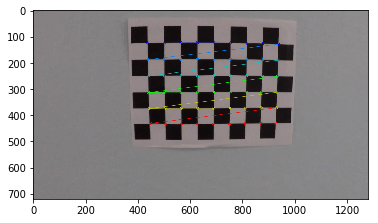

In [6]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

for index,file_name in enumerate(images):
    img= cv2.imread(file_name)
    gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #converting to Grayscale before finding Chessboard Corners

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(img, (9,6), None)

    # If corners are found, add object points and image points
    if ret==True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # Drawing Chessboard Corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)

# Display one example
plt.imshow(img)
    
# From Step 2 we get the Object Points and Image Points

### 1.3. Calculate undistortion parameters from chess images

Text(0.5,1,'Undistorted Images')

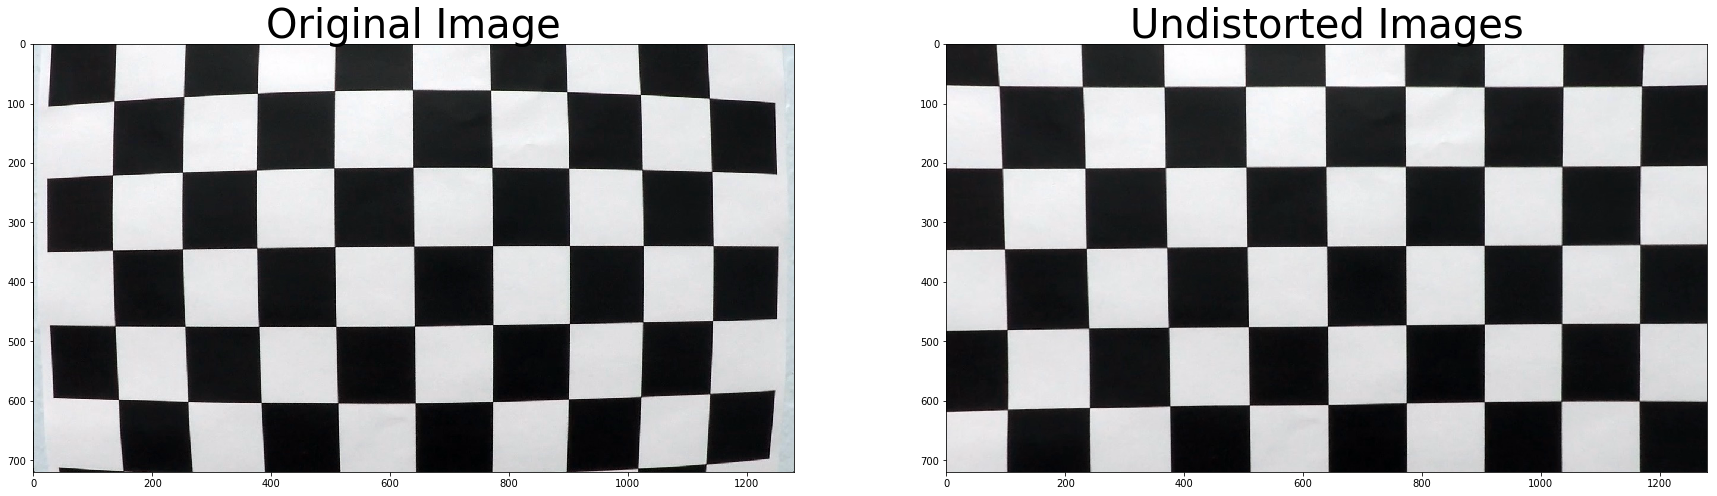

In [8]:
# Calculate Undistortion Parameters
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, axes= plt.subplots(1,2,figsize=(30,30))

axes[0].imshow(img)
axes[0].set_title("Original Image", fontsize=40)
axes[1].imshow(dst)
axes[1].set_title("Undistorted Images", fontsize=40)

From this step (1.3) we get two important parameters:
* mtx(camera matrix)
* dist(distortion coefficient)

Now, we will use these parameters to undistort our road images

### 1.4. Use the parameters to undistort road images

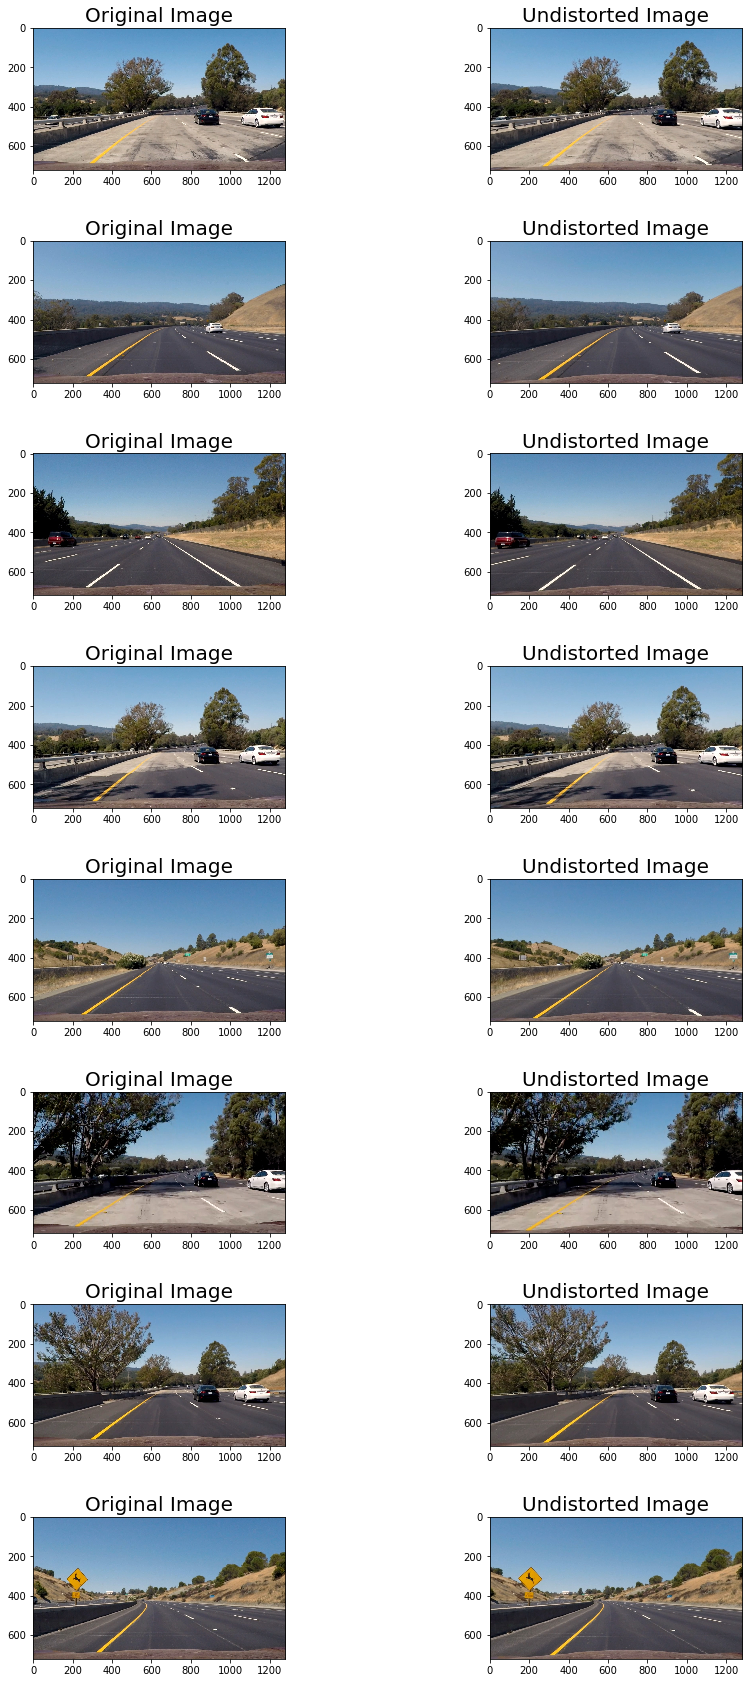

In [9]:
# Undistort road images

## Load images
images = glob.glob('test_images/*.jpg')

## Define undistort function
def cal_undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

## Initialize plots
f, axes = plt.subplots(8, 2, figsize=(15,30))
f.subplots_adjust(hspace=0.5)

## store images in a list
original_images_list = []

for index, image in enumerate(images):
    original_image= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    original_images_list.append(original_image)
    axes[index,0].imshow(original_image)
    axes[index,0].set_title("Original Image", fontsize=20)
    undistorted_image = cal_undistort(original_image) # undistorting image 
    axes[index,1].set_title("Undistorted Image", fontsize=20)
    axes[index,1].imshow(undistorted_image)

## 2. Region of Interest (ROI) and Perspective Transform

### 2.1. Source and Destination Points

In [16]:
# Define source and destination points 
src = np.float32([[150,720],
                  [590,450],
                  [700,450],
                  [1250,720]])

dst= np.float32([[200,720], 
                 [200,0], 
                 [980,0], 
                 [980,720]])

### 2.2. ROI function and perspective transform function

In [17]:
# ROI function: Draw trapezium using the source coordinate
def ROI(originalImage):
    roi_image = cv2.polylines(originalImage, np.int32([src]), True,(0,0,255),10)
    return roi_image

# Warp function: Map source to destination points, to have a bird eyeview of the road image
def warp(image):
    y=image.shape[0]
    x=image.shape[1]

    # Compute perspective transform M
    M = cv2.getPerspectiveTransform(src,dst)
    
    # Create warped image - uses linear transformation
    warped = cv2.warpPerspective(image, M, (x,y), flags=cv2.INTER_LINEAR)
    
    return warped

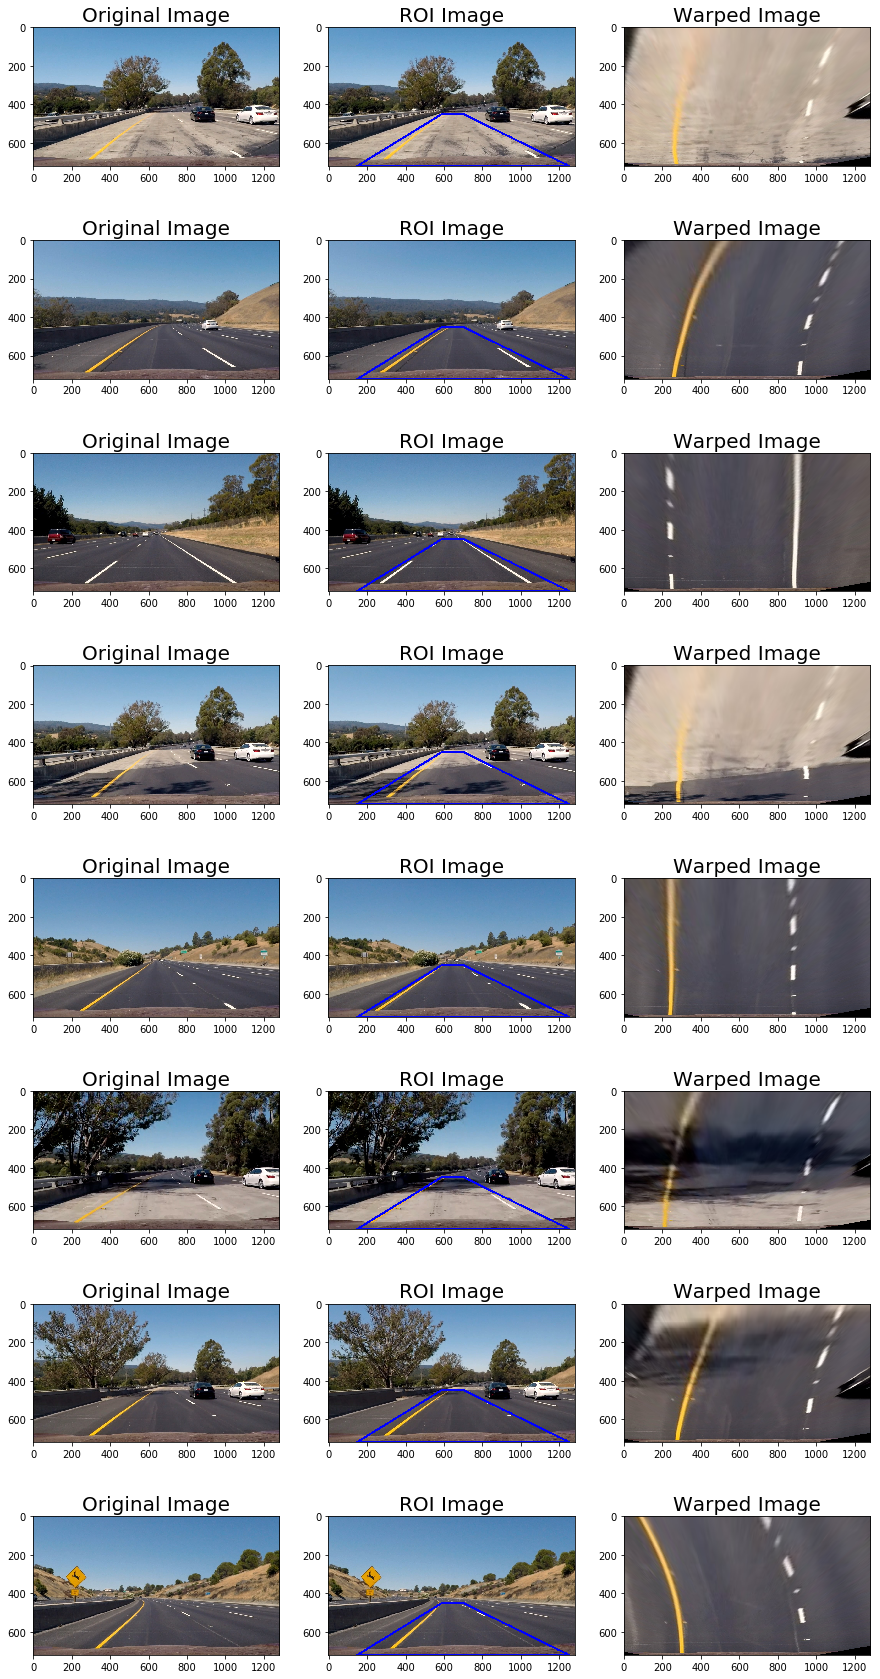

In [18]:
# Testing ROI and perspective transform on test images

f, axes= plt.subplots(8,3,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

warped_images_list=[]
for index, image in enumerate(images):
    
    original_image= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    untouched_image = original_image.copy()
    
    # Define ROI image
    roi_image = ROI(original_image)
    
    # Perspective transform
    warped_image = warp(untouched_image)
    warped_images_list.append(warped_image)
    
    ## Plot images
    axes[index,0].imshow(untouched_image)
    axes[index,0].set_title("Original Image", fontsize=20)
    axes[index,1].imshow(roi_image)
    axes[index,1].set_title("ROI Image", fontsize=20)
    axes[index,2].imshow(warped_image)
    axes[index,2].set_title("Warped Image", fontsize=20)

## 3. Color and Gradient Threshold

### 3.1 Color Threshold

In [19]:
def extract_channel(image, threshold, channel):
    extracted_channel = image[:,:,channel]
    binary = np.zeros_like(extracted_channel)
    binary[(extracted_channel >= threshold[0]) & (extracted_channel <= threshold[1])] = 1
    return binary

In [20]:
# Redefine images to use
images_list = warped_images_list

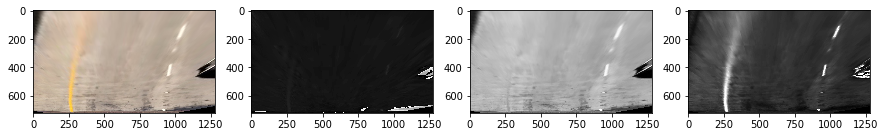

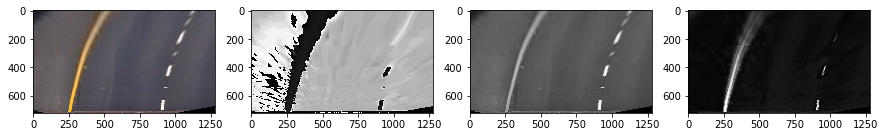

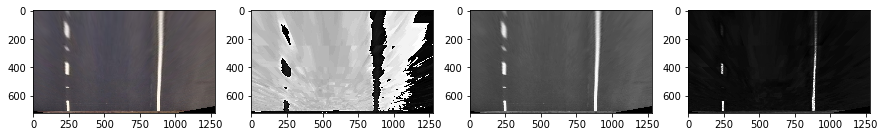

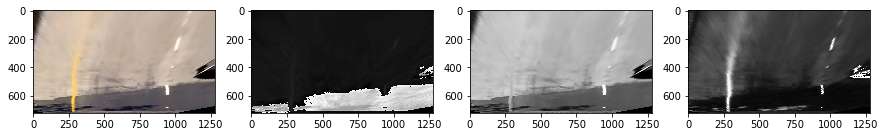

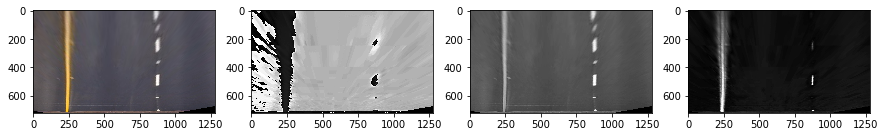

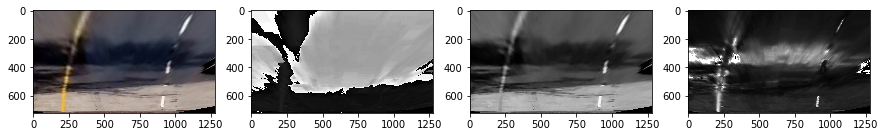

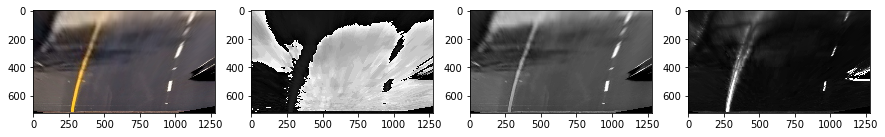

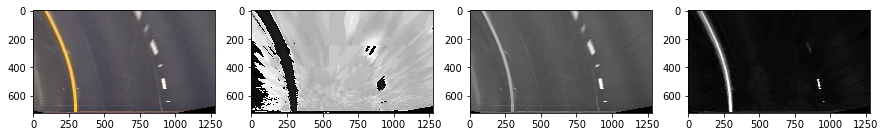

In [21]:
# Look at HLS(Hue, Lightness, Saturation)
for image in images_list:
    plt.figure(figsize=(15,20))
    plt.subplot(1,4,1)
    plt.imshow(image)
    new_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    for channel in range(3):
        isolated_channel_image = new_img[:,:,channel]
        plt.subplot(1,4,channel+2)
        plt.imshow(isolated_channel_image, cmap='gray')
    plt.show()

We choose to combine the output of L and S channel for our lane line color thresholding

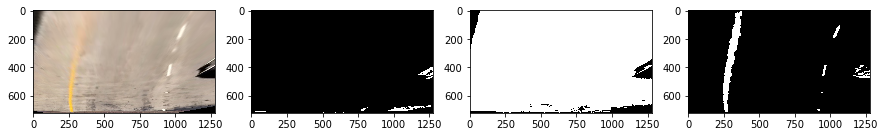

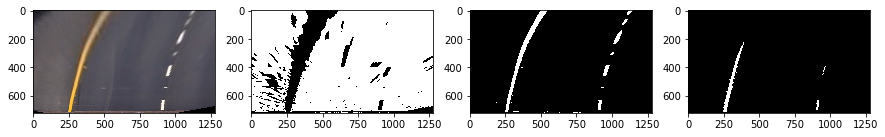

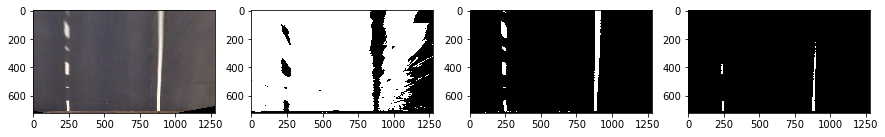

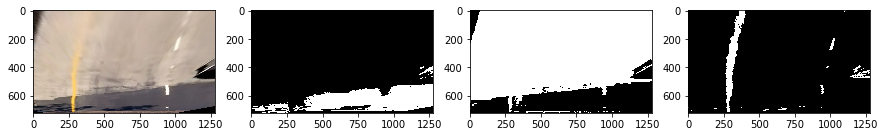

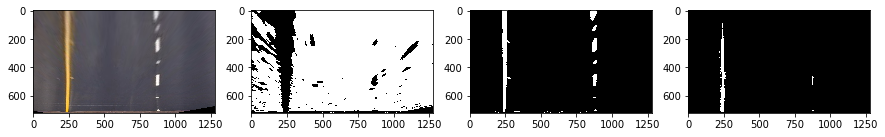

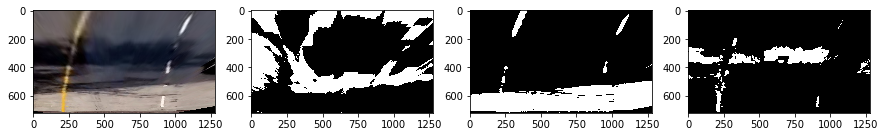

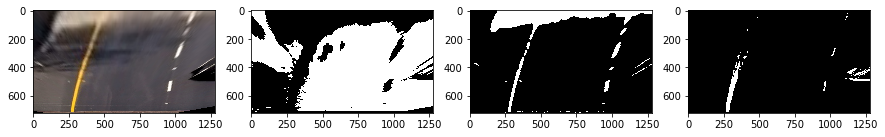

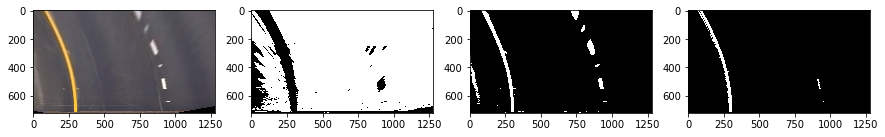

In [22]:
threshold= [120,255]

## HLS Channel Thresholding
for image in images_list:
    plt.figure(figsize=(15,20))
    plt.subplot(1,4,1)
    plt.imshow(image)
    new_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    for channel in range(3):
        isolated_channel_image = extract_channel(new_img, threshold, channel)
        plt.subplot(1,4,channel+2)
        plt.imshow(isolated_channel_image, cmap='gray')
    plt.show()

From the results, we decide to use both L and S channel from HLS space for lane lines color threshold

### 3.2. Gradient Threshold

In [23]:
def sobel_function(warpedimage, threshold, sobel_axis, kernel_size=3):
    
    gray = cv2.cvtColor(warpedimage, cv2.COLOR_RGB2GRAY) # Step 1- Convert to GrayScale
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    grad= np.sqrt(sobelx**2 + sobely**2)
    
    arctan= np.arctan2(abs_sobely,abs_sobelx)
    
    valParam=abs_sobelx
    
    if(sobel_axis=='x'):
        valParam=abs_sobelx
    elif(sobel_axis=='y'):
        valParam= abs_sobely
    elif(sobel_axis=='xy'):
        valParam= grad
    
    img = np.uint8((valParam* 255)/np.max(valParam)) # Creating a normalized sobel image
    binary_output = np.zeros_like(img)
    binary_output[(img > threshold[0]) & (img < threshold[1])]=1
    return binary_output

In [24]:
images = glob.glob('test_images/*.jpg') # Reading Images from test_images folder

Text(0.5,1,'Magnitude')

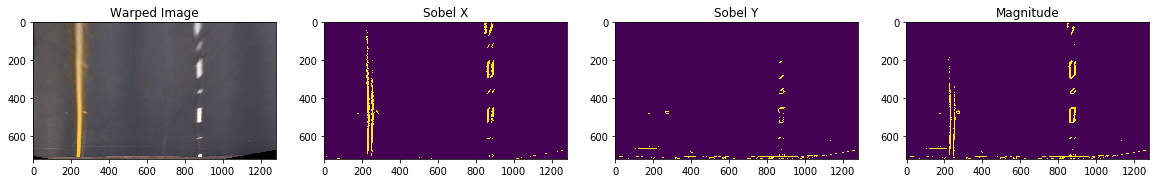

In [25]:
# testing sobel on test_image and warped image
f, axes= plt.subplots(1,4,figsize=(20,8))

threshold=[20,100]

warped_image = warped_images_list[4]

axes[0].imshow(warped_image)
axes[0].set_title("Warped Image")

sobelx=sobel_function(warped_image,threshold,'x')
axes[1].imshow(sobelx)
axes[1].set_title("Sobel X")

sobely=sobel_function(warped_image,threshold,'y')
axes[2].imshow(sobely)
axes[2].set_title("Sobel Y")

sobelxy=sobel_function(warped_image,threshold,'xy')
axes[3].imshow(sobelxy)
axes[3].set_title("Magnitude")

### 3.3. Color and gradient threshold combination

In [26]:
# Combining color and sobel thresholding

def combine(warped_image):
    
    ## change image to HLS Space
    image = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HLS)

    ## Color threshold
    l_color_threshold = [180, 255]
    s_color_threshold = [120, 255]
    l_channel = extract_channel(image, l_color_threshold,1)
    s_channel = extract_channel(image, s_color_threshold,2)
    
    ## Sobel x threshold
    sobel_threshold = [20, 100]
    sobelx = sobel_function(warped_image, sobel_threshold, 'x')
    
    combined_binary = np.zeros_like(s_channel)
    combined_binary[((s_channel == 1) & (l_channel==1)) | (sobelx == 1)  ] = 1
    return combined_binary

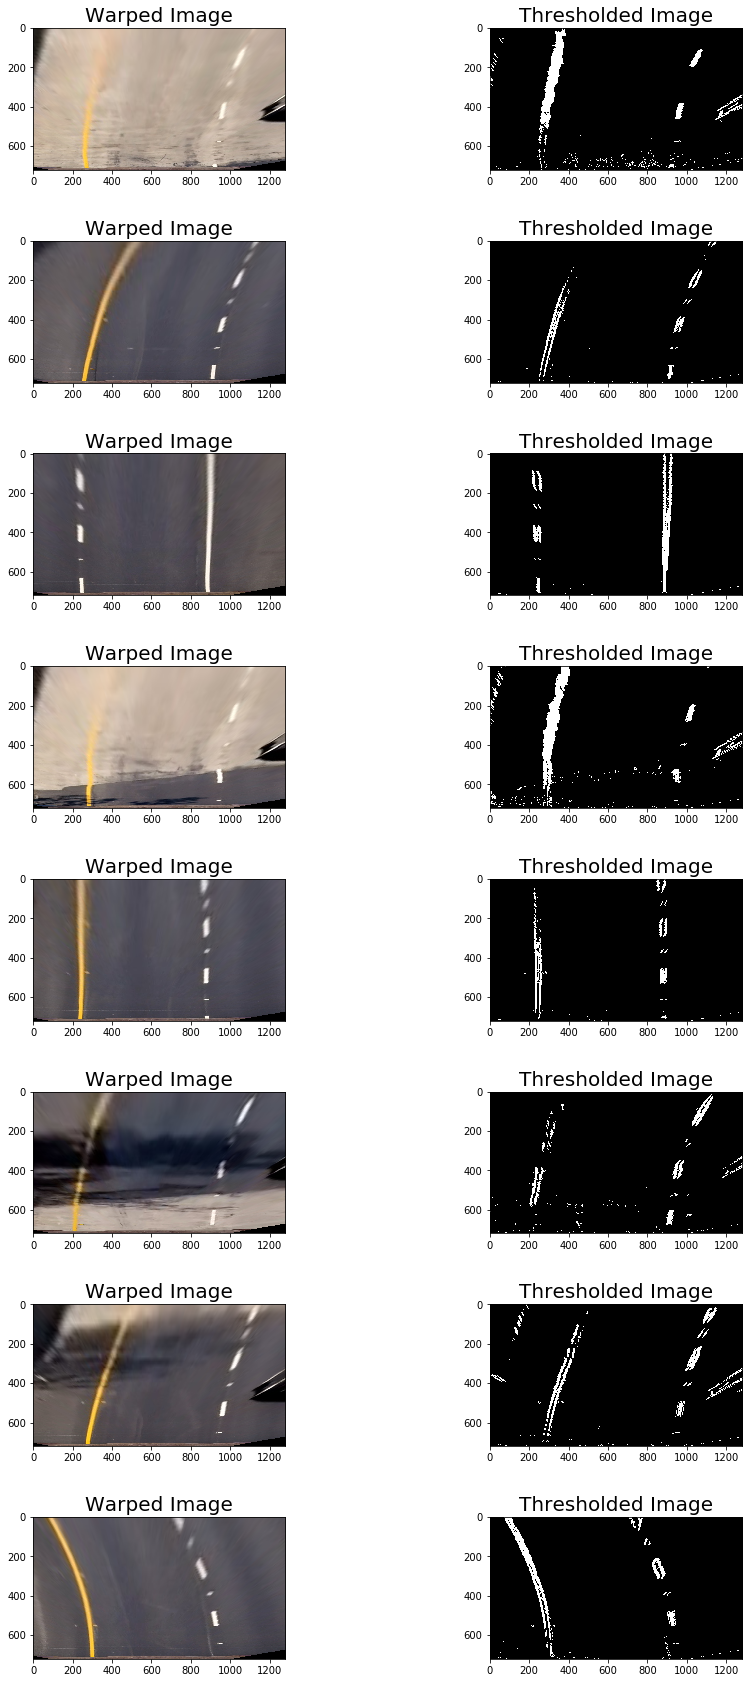

In [27]:
#testing on test_images
f, axes= plt.subplots(8,2,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

for index,warped in enumerate(warped_images_list):
    combined_image = combine(warped)
    axes[index,0].imshow(warped)
    axes[index,0].set_title("Warped Image", fontsize=20)
    axes[index,1].imshow(combined_image,cmap='gray')
    axes[index,1].set_title("Thresholded Image", fontsize=20)

### 4. Histogram

In [28]:
def histogram_function(warped_image):
    return np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)

Text(0.5,1,'Histogram Image 2')

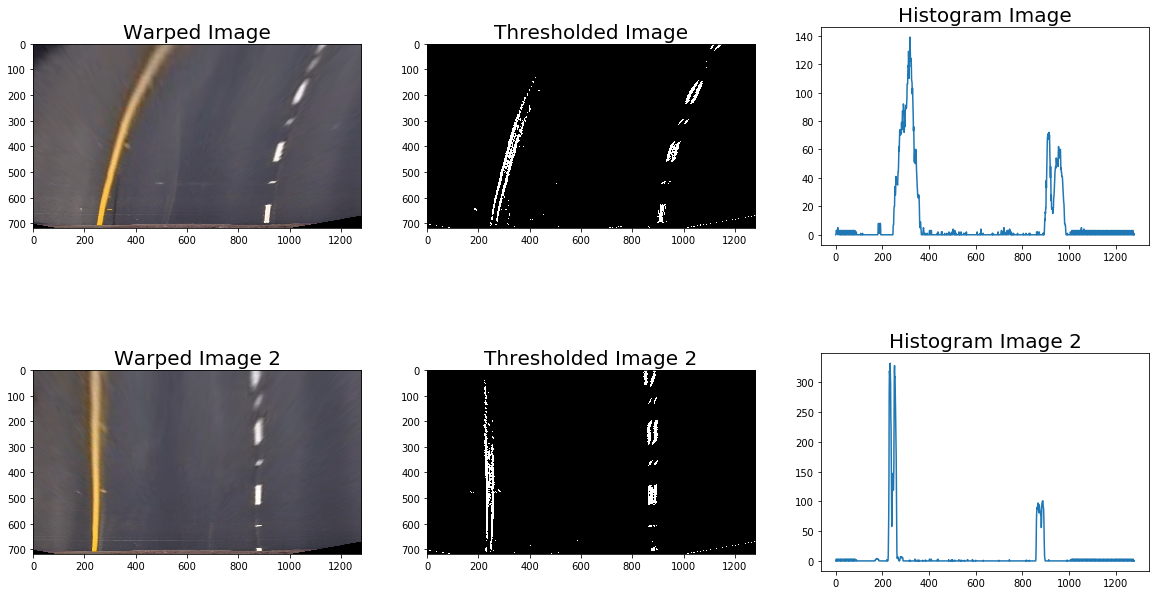

In [29]:
# testing it on test images

image_1 = warped_images_list[1]
image_2 = warped_images_list[4]

f, axes= plt.subplots(2,3,figsize=(20,10))
f.subplots_adjust(hspace=0.5)

axes[0,0].imshow(image_1)
axes[0,0].set_title("Warped Image", fontsize=20)
combined_1 = combine(image_1)
axes[0,1].imshow(combined_1,cmap="gray")
axes[0,1].set_title("Thresholded Image", fontsize=20)
histogram_1 = histogram_function(combined_1)
axes[0,2].plot(histogram_1)
axes[0,2].set_title("Histogram Image", fontsize=20)

axes[1,0].imshow(image_2)
axes[1,0].set_title("Warped Image 2", fontsize=20)
combined_2 = combine(image_2)
axes[1,1].imshow(combined_2,cmap="gray")
axes[1,1].set_title("Thresholded Image 2", fontsize=20)
histogram_2 = histogram_function(combined_2)
axes[1,2].plot(histogram_2)
axes[1,2].set_title("Histogram Image 2", fontsize=20)

### 4.1 Sliding Windows

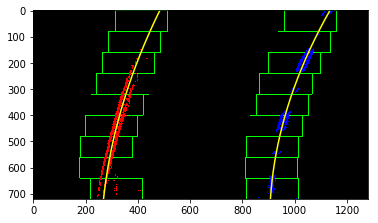

In [30]:
def find_lane_windows(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# Use polynomial function to fit line
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_windows(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(combined_1)

plt.imshow(out_img)

### 4.2. Draw smoothed windows

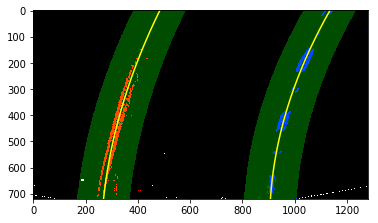

In [31]:
def search_around_poly(binary_warped, draw=False):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    leftx, lefty, rightx, righty, out_img = find_lane_windows(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    # Plot the polynomial lines onto the image
    if draw == True:
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    
    else:
        result = None
    ## End visualization steps ##
    
    return result, left_fit, right_fit

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_fit, right_fit = search_around_poly(combined_1, draw=True)

# View your output
plt.imshow(result)

## 5. Unwarp Images

### 5.1. Redefine source and destination points

In [32]:
# Redefine source and destination points for inversion/unwarped
src = np.float32([[150,720],
                  [590,450],
                  [700,450],
                  [1250,720]])

dst= np.float32([[200,720], 
                 [200,0], 
                 [980,0], 
                 [980,720]])

### 5.2. Unwarp and draw line in the unwarped images

In [33]:
# Unwarp Image and plot line

def draw_line(original_image,binary_warped, left_fit, right_fit):
    
    h,w= binary_warped.shape
    Minv = cv2.getPerspectiveTransform(dst, src)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=25)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=25)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    #axes[index+1].imshow(newwarp)
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 1, 0)
    return result

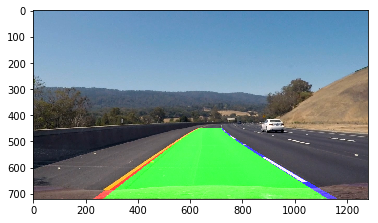

In [34]:
# testing it on test image

original_image = images[1]
original_image = cv2.cvtColor(cv2.imread(original_image), cv2.COLOR_BGR2RGB)
result, left_lane, right_lane = search_around_poly(combined_1, draw=False)
output_image = draw_line(original_image, combined_1, left_lane, right_lane)
plt.imshow(output_image)

## 6. Lane Radius & Vehicle Deviation from Centre

In [47]:
def calculate_lane_radius(binary_warped,left_fit,right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    positionCar= binary_warped.shape[1]/2
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    
    y_eval=np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    actualPosition= (left_lane_bottom+ right_lane_bottom)/2
    
    distance= (positionCar - actualPosition)* xm_per_pix
    
    deviation = "Center"
    
    if distance > 0:
        deviation = "Right"
        
    elif distance < 0:
        deviation = "Left"
        
    distance = abs(round(distance, 2))
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return (left_curverad + right_curverad)/2, distance, deviation
    # Example values: 632.1 m    626.2 m

In [48]:
result, left_lane, right_lane = search_around_poly(combined_1, draw=False)

calculate_lane_radius(combined_1, left_lane, right_lane )

(544.60347941723899, 0.89000000000000001, 'Left')

## 7. Final Pipeline

In [66]:
def pipeline(image):
    original_image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undistorted_image = cal_undistort(original_image) # undistorting image 
    warped_image = warp(undistorted_image)
    combined_image= combine(warped_image)
    result, left_lane, right_lane = search_around_poly(combined_image, draw=False)
    #VisualizeSlidingWindow(combinedImage, left_fit,right_fit, returnedOutput[2], returnedOutput[3],returnedOutput[4])
    final_image= draw_line(original_image,combined_image,left_lane,right_lane)
    #cv2.imwrite('./test/'+str(randint(0, 99999))+'.jpg',originalImage)
    
    radius, distance, deviation = calculate_lane_radius(combined_image,left_lane,right_lane)
    cv2.putText(final_image,"Radius of Curvature: " + str(int(radius))+ "m", (100,100), 2, 1, (0,0,0),2)
    #print(distance)
    cv2.putText(final_image,"Deviation: " + str(distance) + "m " + deviation, (100,150), 2, 1, (0,0,0),2)
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d %H%M%S')
        
    cv2.imwrite('./Output_1/'+str(st)+'.jpg',original_image)
    
    cv2.imwrite('./Output_1/'+str(st)+'_o.jpg',final_image)
    new_combined_image= np.dstack((combined_image*255,combined_image*255,combined_image*255))
    final_image[100:240,1000:1200, :]= cv2.resize(new_combined_image, (200,140))
    return cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

### 7.1. Test on Images

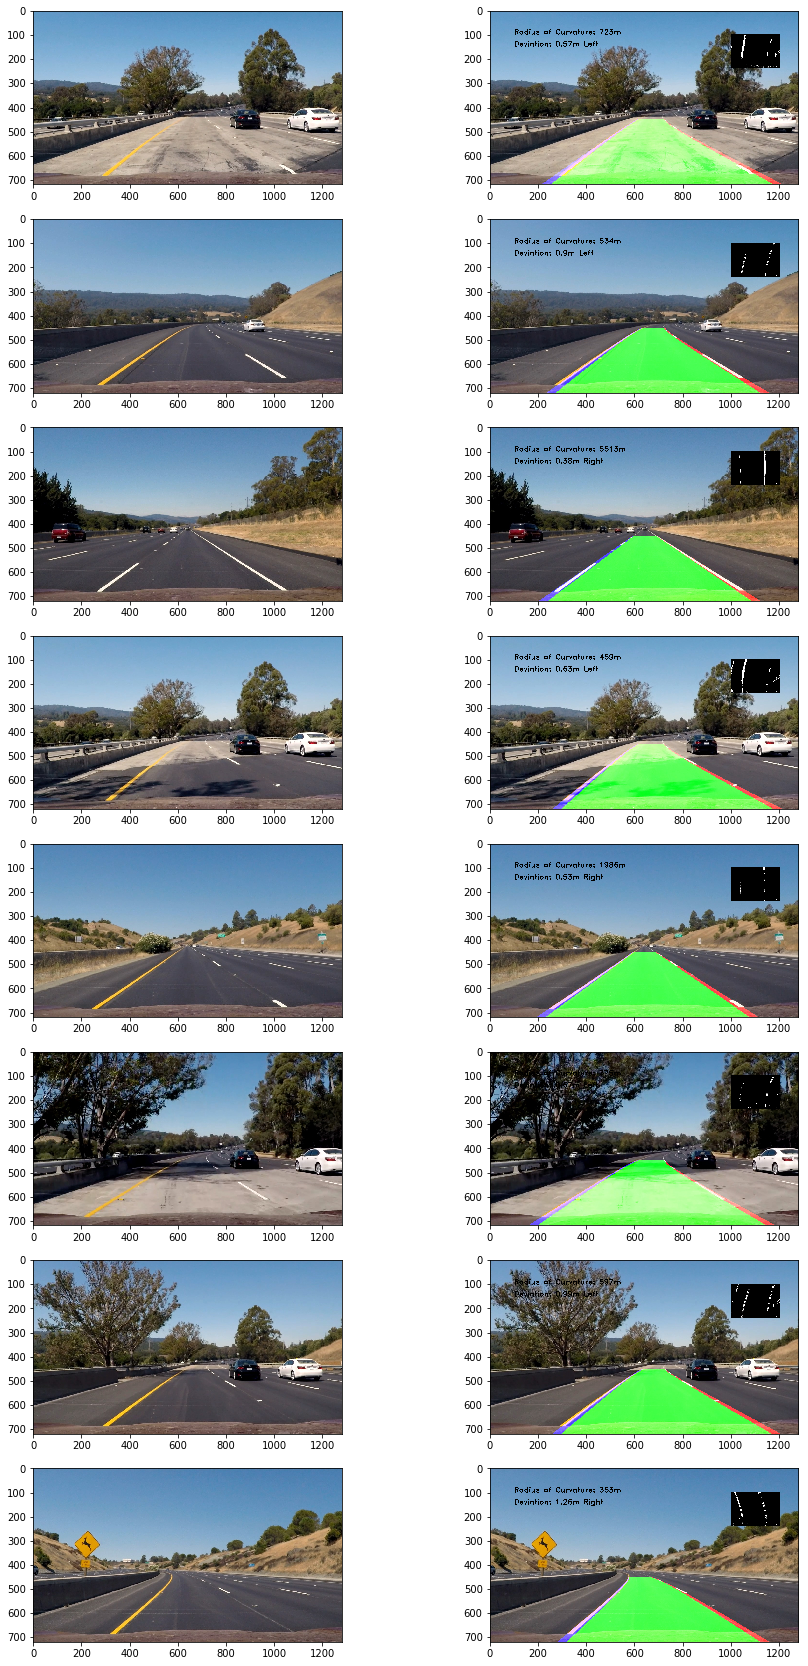

In [67]:
#testing on test images
f, axes= plt.subplots(8,2,figsize=(15,30))

images = glob.glob('test_images/*.jpg') # Reading Images from test_images folder

for index, image in enumerate(images):
    input_image= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    final_image=pipeline(input_image)
    cv2.imwrite('output_images/'+str(index)+'.jpg', cv2.cvtColor(final_image,cv2.COLOR_BGR2RGB))
    axes[index,0].imshow(input_image)
    axes[index,1].imshow(final_image)

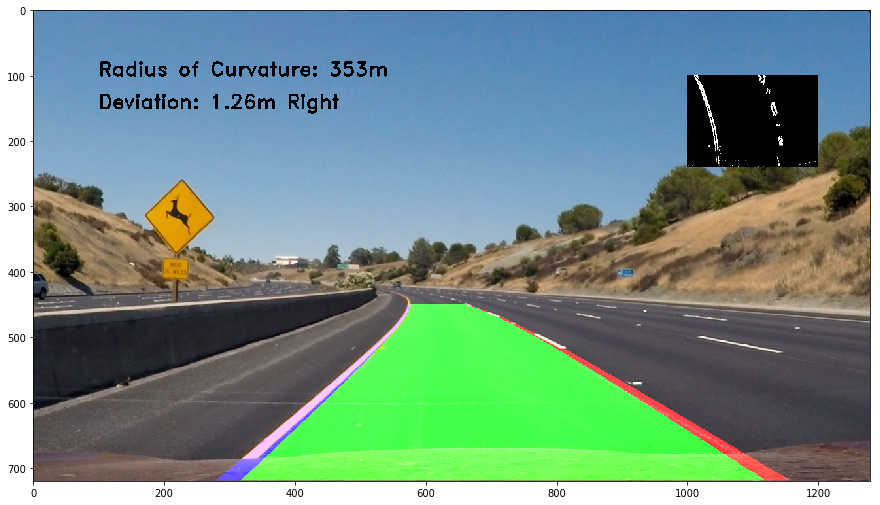

In [68]:
show_image = images[2]
f, axes= plt.subplots(figsize=(15,30))

input_image= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
final_image=pipeline(input_image)
#cv2.imwrite('output_images/'+str()+'.jpg', cv2.cvtColor(final_image,cv2.COLOR_BGR2RGB))
axes.imshow(final_image)
#axes[1].imshow(final_image)

### 7.2. Test on Videos

In [69]:
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:00<00:00,  4.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 55s, sys: 2.93 s, total: 2min 58s
Wall time: 5min 3s


In [70]:
myclip = VideoFileClip("project_video_output.mp4")
myclip.write_gif("test.gif")


[MoviePy] Building file test.gif with imageio


100%|█████████▉| 1260/1261 [06:29<00:00,  3.30it/s]


In [71]:
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'challenge_video_output.mp4'
video_input1 = VideoFileClip('challenge_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [02:04<00:00,  3.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 5s, sys: 12.6 s, total: 1min 18s
Wall time: 2min 6s
